In [196]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ast import literal_eval
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
import sympy as sym
from sympy.parsing import mathematica
import numpy as np

In [197]:
plt.rcParams['text.usetex'] = False

In [198]:

RESULTS_DIR = "paper_results"
benchmarks = [
    "rational_2",
    "sqrt",    
    "rational",
    "rational_sqrt",   
]

benchmarks_id= {
    
    "rational":'a',
    "rational_2":'b',
    "sqrt":'c',
    "rational_sqrt":'d',
}


In [199]:
def process_output(row):
    
    try:
        if (type(row)==list) and (len(row)>0):
            row = np.asarray(row)
            return (row.mean()-row.std(), row.mean()+row.std()) 
    except:
        pass

    try:
        if (type(row)==list) and (len(row)==0):
            return (None, None) 
    except:
        pass


    try:
        row = float(row)
        return (row, row)
    except:
        pass

    try:
        return literal_eval(str(row).strip())
    except Exception as e:
        pass
    
    try:
        for w in ['integrate', 'boole']:
            if w in row.lower():
                return (None, None)        
        
        row = row.replace("[",'(').replace("]", ")").replace("L", "l").replace("E(p_) =", "").replace("^", "**").strip()
        row = sym.parse_expr(row).evalf()
        
        return (row,row)
        
    except Exception as e:
        print(e, row)
    
        
    return (None, None)

In [200]:
def process_time(row):
    if pd.isnull(row):
        return None

    try:
        row = float(row)
        return row
    except:
        pass

    try:
        return literal_eval(str(row).strip())[0]
    except Exception as e:
        pass
        
    except Exception as e:
        print(e, row)
    
        
    return None

In [201]:
def process_benchmark(benchmark):
    df_list = []
    for f_name in os.listdir(os.path.join(RESULTS_DIR, benchmark)):
        tool_name =  f_name.split("_")[-2]
        df_ = pd.read_csv(os.path.join(RESULTS_DIR, benchmark, f_name))
        df_['tool'] = tool_name
        df_['details'] = df_['details'].apply(literal_eval)
        if tool_name == 'volesti': 
            df_['output'] = df_['details'].apply(lambda d: list([x['output'] for x in d]))    
        df_list.append(df_[['index', 'tool','output', 'time', 'details']])
    df = pd.concat(df_list, ignore_index=True)

    df['output'] = df['output'].apply(process_output)
    df['time'] = df['time'].apply(process_time)
    
    df['lower'], df['upper'] = df['output'].apply(lambda o: o[0]),df['output'].apply(lambda o: o[1])
    df['error'] = df['upper']-df['lower']
    df['error_norm'] = MinMaxScaler().fit_transform(df['error'].values.reshape(-1,1))
    df['benchmark'] = benchmark
    df['id'] = df['index'].apply(lambda x: benchmarks_id[benchmark] + str(x).zfill(2))
    df['timeout'] = df['time'].apply(lambda x: x>3600)
    df['is_solved'] = (~pd.isnull(df['error']))&(df['time']<=3600)
    return df

In [202]:
df_b_list = []
for b in benchmarks:
    df_b_list.append(process_benchmark(b))

df_b = pd.concat(df_b_list)
df_b.head()

,index,tool,output,time,details,lower,upper,error,error_norm,benchmark,id,timeout,is_solved
0,0,latte,"(nan, nan)",0.078246,[],NaN,NaN,NaN,NaN,rational_2,b00,False,False
1,1,latte,"(nan, nan)",0.058846,[],NaN,NaN,NaN,NaN,rational_2,b01,False,False
2,2,latte,"(nan, nan)",0.053086,[],NaN,NaN,NaN,NaN,rational_2,b02,False,False
3,3,latte,"(nan, nan)",0.048246,[],NaN,NaN,NaN,NaN,rational_2,b03,False,False
4,4,latte,"(nan, nan)",0.052024,[],NaN,NaN,NaN,NaN,rational_2,b04,False,False


In [203]:
def calcPlotID(bench):
    if bench.benchmark == 'rational':
        return 'A'+str(bench['index']+1)
    elif bench.benchmark == 'rational_2':
        return 'A'+str(bench['index']+30+1)
    if bench.benchmark == 'sqrt':
        return 'B'+str(bench['index']+1)
    elif bench.benchmark == 'rational_sqrt':
        return 'B'+str(bench['index']+30+1)
    
    return 0


df_b['plotID'] = df_b.apply(calcPlotID, axis=1)
df_b['catID'] = df_b['plotID'].str[:1]

df_b.head()

,index,tool,output,time,details,lower,upper,error,error_norm,benchmark,id,timeout,is_solved,plotID,catID
0,0,latte,"(nan, nan)",0.078246,[],NaN,NaN,NaN,NaN,rational_2,b00,False,False,A31,A
1,1,latte,"(nan, nan)",0.058846,[],NaN,NaN,NaN,NaN,rational_2,b01,False,False,A32,A
2,2,latte,"(nan, nan)",0.053086,[],NaN,NaN,NaN,NaN,rational_2,b02,False,False,A33,A
3,3,latte,"(nan, nan)",0.048246,[],NaN,NaN,NaN,NaN,rational_2,b03,False,False,A34,A
4,4,latte,"(nan, nan)",0.052024,[],NaN,NaN,NaN,NaN,rational_2,b04,False,False,A35,A


In [204]:
df_b['tool'].unique()

array(['latte', 'alpha', 'gubpi', 'volesti', 'mathematica', 'wmilp',
       'psi'], dtype=object)

In [205]:
df_b[(df_b['tool']=='gubpi')&(df_b['is_solved']==False)]

,index,tool,output,time,details,lower,upper,error,error_norm,benchmark,id,timeout,is_solved,plotID,catID
60,0,gubpi,"(nan, nan)",0.281219,[],NaN,NaN,NaN,NaN,sqrt,c00,False,False,B1,B
71,11,gubpi,"(nan, nan)",0.287101,[],NaN,NaN,NaN,NaN,sqrt,c11,False,False,B12,B
79,19,gubpi,"(nan, nan)",0.292058,[],NaN,NaN,NaN,NaN,sqrt,c19,False,False,B20,B
81,21,gubpi,"(nan, nan)",0.276265,[],NaN,NaN,NaN,NaN,sqrt,c21,False,False,B22,B
84,24,gubpi,"(nan, nan)",0.290052,[],NaN,NaN,NaN,NaN,sqrt,c24,False,False,B25,B
86,26,gubpi,"(nan, nan)",0.286644,[],NaN,NaN,NaN,NaN,sqrt,c26,False,False,B27,B
89,29,gubpi,"(nan, nan)",0.290998,[],NaN,NaN,NaN,NaN,sqrt,c29,False,False,B30,B


In [206]:
df_b.groupby(['tool']).agg({
    'time': ['mean', 'max'],
    'error': ['mean', 'max'],
    
    'is_solved': ['count', 'sum'],
    'timeout': ['sum'],
}).round(3)

time               error            is_solved      timeout
                mean       max      mean        max     count  sum     sum
tool                                                                      
alpha          3.922     5.983       0.0        0.0       120  120       0
gubpi          0.494     0.720  3.671111  31.569187       120  113       0
latte          0.020     0.109       NaN        NaN       120    0       0
mathematica   79.900  2326.064       0.0          0       120   85       0
psi          787.480  3626.377       0.0          0       120   20      20
volesti        0.048     0.132   0.51587   3.645832       120   60       0
wmilp        644.727  3623.372  0.112164   0.867839       120  107      13

On 120 benchmarks, PSI solved 20, timed out on 20, and failed to solve 80 (results contained integrals or were unable to evaluate the expression to a numeric value).


In [207]:
df_b = df_b[df_b.tool.isin(['volesti', 'wmilp', 'gubpi'])]
len(df_b)

360

In [208]:
selected_bench = "sqrt"
samples = list(df_b[df_b['benchmark']==selected_bench]['id'].unique())

In [209]:
selected_bench = 'selectedBench'
samples_plotIDs = ['A12', 'A17', 'A22', 'A30', 'A41', 'A49', 'A53', 'B11', 'B17', 'B18', 'B24', 'B32', 'B35', 'B38']
samples = list(df_b[df_b['plotID'].isin(samples_plotIDs)]['id'].unique())
samples

['b10',
 'b18',
 'b22',
 'c10',
 'c16',
 'c17',
 'c23',
 'a11',
 'a16',
 'a21',
 'a29',
 'd01',
 'd04',
 'd07']

In [210]:
selected_bench = 'sampledBenchA'
samples_plotIDs = pd.Series(df_b[df_b['catID'] == 'A']['plotID'].unique()).sample(30, random_state=42).tolist()
samples = list(df_b[df_b['plotID'].isin(samples_plotIDs)]['id'].unique())
samples

['b00',
 'b03',
 'b04',
 'b05',
 'b06',
 'b08',
 'b09',
 'b12',
 'b13',
 'b15',
 'b17',
 'b19',
 'b25',
 'b27',
 'a00',
 'a01',
 'a03',
 'a04',
 'a06',
 'a10',
 'a13',
 'a15',
 'a16',
 'a18',
 'a20',
 'a22',
 'a24',
 'a26',
 'a27',
 'a28']

In [211]:
df_ = df_b[df_b['id'].isin(samples)]
df_ = df_.sort_values('id', ascending=False)
df_.tail()

,index,tool,output,time,details,lower,upper,error,error_norm,benchmark,id,timeout,is_solved,plotID,catID
61,1,volesti,"(0.015627040461310616, 0.018002879538689384)",0.082817,"[{'N': 1000, 'repeat': 0, 'n_integrations': 1,...",0.015627,0.018003,0.002376,7.525817e-05,rational,a01,False,True,A2,A
31,1,gubpi,"(0.01718335837663654, 0.017184861067956064)",0.418703,{'raw_output': '{ method = Polytopes discret...,0.017183,0.017185,0.000002,4.759994e-08,rational,a01,False,True,A2,A
120,0,wmilp,"(5.739643790159522, 5.83927926866968)",68.584290,"{'n_integrations': 1, 'mode': 'SAE4WMI', 'outp...",5.739644,5.839279,0.099635,3.156099e-03,rational,a00,False,True,A1,A
30,0,gubpi,"(0.0, 5.787299548244)",0.464201,{'raw_output': '{ method = Polytopes discret...,0.0,5.7873,5.7873,1.833211e-01,rational,a00,False,True,A1,A
60,0,volesti,"(5.430228393704708, 5.8876876062952945)",0.067337,"[{'N': 1000, 'repeat': 0, 'n_integrations': 1,...",5.430228,5.887688,0.457459,1.449069e-02,rational,a00,False,True,A1,A


In [212]:
colors = sns.color_palette()

y_pos = {
    "wmilp": 0.21,
    "gubpi": 0.5,
    "volesti": 0.79,
    # "latte":0.5,
    # "psi": 0.5
}

color_map = {
    'wmilp': colors[2], #green
    'gubpi': colors[1], #Orange
    'volesti': colors[3], #red
    'latte': colors[5], # Yellow
    'psi': colors[4],#Pink    
}

marker_map = {
    'wmilp': '.', 
    'gubpi': '.', 
    'volesti': '.', 
    'latte': "|",
    'psi': "|",    
}

name_map = {
    'wmilp': "WMI-LP", #green
    'gubpi': "GuBPI", #Orange
    'volesti': "WMI-PA(Volesti)", #red
    'latte': "WMI-PA(latte)", # Yellow
    'psi': "PsiSolver",#Pink    
}



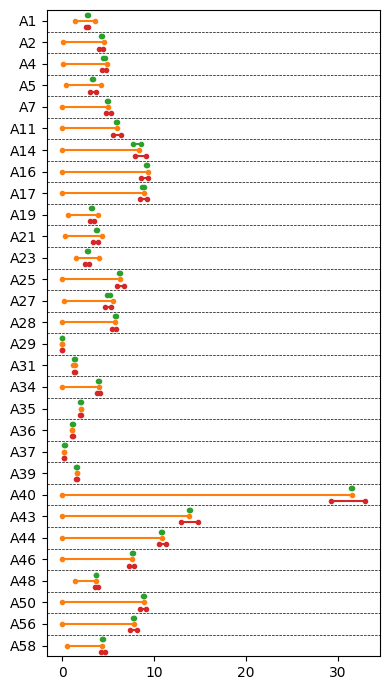

In [213]:
plt.figure(figsize=(4,7))

# # Put example lines
for i in range(len(samples)):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)




for i, row in df_.iterrows():
    # print(row['id'], row['tool'])
    plt.plot([row['lower'],row['upper']],[len(samples)-samples.index(row['id'])-y_pos[row['tool']],len(samples)-samples.index(row['id'])-y_pos[row['tool']]], color=color_map[row['tool']], linewidth=1.5, label=name_map[row['tool']], marker=marker_map[row['tool']])
    # plt.plot([0,0.005],[2,2])

plt.ylim((0,len(samples)))
# plt.xlim((0,1))

# plt.xlabel('WMI Results (Upper and Lower Bounds)')
# plt.ylabel('WMI Instance ID')
# plt.title(f"{bench_title_map[bench]}: {bench_template_map[bench]}")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.yticks(ticks=[len(samples)-i-0.5 for i in range(0,len(samples))], labels=reversed(df_['plotID'].unique()))
plt.tight_layout()
plt.xticks(None)
os.makedirs(os.path.join(RESULTS_DIR, 'plots'), exist_ok=True)
plt.savefig(os.path.join(RESULTS_DIR, 'plots', f"{selected_bench.replace('/', '_')}.pdf"), dpi=500)